# <p style ="text-align: center">The People & Blogs Category</p>

This is notebook contains the main logic of our data collection and plot generation for the 3rd and final milestone of the Applied Data Analysis course.

> **Important Note**: Most of the plots were removed due to the fact that they were interactive plots, this notebook merely serves to show the logic behind. Moreover, these plots made the notebook too large, which made github refuse to display it since it exceeded size constraints.

## Imports

In [ ]:
import numpy as np
import os 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

## plotting
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as pyo

## tag analysis
from wordcloud import WordCloud
from collections import Counter
import gensim.downloader as api
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

## nlp and viz
import pyLDAvis
import pyLDAvis.lda_model
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
import re

from utils.loading import *
from utils.plotting import *

Join us on a journey through YouTube's dynamic landscape as we unravel the transformation of channels within the People & Blogs category over the past decade. From sudden pivots to strategic shifts, we delve into the reasons behind channels morphing in this vibrant space.

What motivates a channel's transition? Was it audience demand, a quest for reinvention, or a strategic play? Our quest is to uncover the motivations and quality that drove these channel metamorphoses. Get ready to decipher the narrative behind YouTube's shape-shifting channels as we navigate through data, decode patterns, and reveal the untold stories behind this intriguing evolution.

## Our Dataset


This data story relies on the Youniverse dataset, a comprehensive repository encompassing YouTube channel data spanning the last decade (2005-2019). It encapsulates key metrics such as views, likes, comments, subscriber counts, and video metadata. The dataset's breadth and depth make it an ideal choice for our analysis, enabling a nuanced exploration of channel transitions within the People & Blogs category.

Let's start by loading the general channel data, as well as their associated time series. The original dataset only consists of channels with at least 10 videos and 10000 subscribers, so we won't need to filter out any channels. These thresholds ensure that we only consider channels with a significant amount of content and a large enough audience to be relevant, and are the basis of our analysis.

In [ ]:
NOTEBOOK_PATH = os.getcwd()
DIR_PATH = os.path.dirname(NOTEBOOK_PATH)
UTILS_PATH = os.path.join(DIR_PATH, "utils")

# data
DATA_PATH = os.path.join(DIR_PATH, "Data_youniverse")
CATEGORY = "People & Blogs"
CATEGORY_FILE_NAME = ''.join(CATEGORY.split(" ")).lower()
CATEGORY_FILE_PATH = os.path.join(DATA_PATH, f"df_channels_{CATEGORY_FILE_NAME}.tsv.gz")

# website data
SITE_DATA_PATH = os.path.join(DIR_PATH, 'website_data')
PEOPLE_AND_BLOGS_PATH = os.path.join(SITE_DATA_PATH, 'People_&_Blogs')

if not os.path.exists(PEOPLE_AND_BLOGS_PATH):
    os.makedirs(PEOPLE_AND_BLOGS_PATH)

#### Data Loading

In [ ]:
df_channels_en = pd.read_csv(f"{DATA_PATH}/df_channels_en.tsv.gz", compression="infer", sep="\t") 
df_timeseries_en = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t")

df_yt_metadata_filtered = pd.read_csv(CATEGORY_FILE_PATH, compression="infer")
df_yt_metadata_filtered['upload_date'] = pd.to_datetime(df_yt_metadata_filtered['upload_date'])
df_yt_metadata_filtered.dropna(subset=['tags'], inplace=True)

In [ ]:
df_channels_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136470 entries, 0 to 136469
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   category_cc         136342 non-null  object 
 1   join_date           136469 non-null  object 
 2   channel             136470 non-null  object 
 3   name_cc             136460 non-null  object 
 4   subscribers_cc      136470 non-null  int64  
 5   videos_cc           136470 non-null  int64  
 6   subscriber_rank_sb  136470 non-null  float64
 7   weights             136470 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 8.3+ MB


In [ ]:
df_channels_en['category_cc'].value_counts()

category_cc
Music                    24285
Entertainment            22951
Gaming                   20143
People & Blogs           18413
Howto & Style            11875
Education                 7803
Film and Animation        6875
Sports                    5148
Science & Technology      4864
Comedy                    3767
Autos & Vehicles          3705
News & Politics           2263
Travel & Events           1989
Pets & Animals            1292
Nonprofits & Activism      969
Name: count, dtype: int64

These first numbers outline already a few heavyweight categories of the Youtube scene over that tiemscale, such as the Music and the Entertainment industries. Our analysis centers on the People & Blogs category due to its prominent representation and unique content dynamics. This category not only boasts a substantial channel count but also offers a diverse range of human-centric content, including personal narratives, vlogs, and informational videos. Moreover, it serves as an engagement magnet, drawing audiences seeking relatable and engaging content while fostering high interaction through comments, shares, and discussions. Additionally, People & Blogs stands out as a transition hotspot, historically attracting channels diversifying their content, making it an intriguing focal point for exploring the dynamic evolution and transitions within the YouTube ecosystem.

## The People and Blogs Category

The People & Blogs category on YouTube serves as a diverse hub, housing a wide spectrum of content primarily centered around personal narratives, experiences, and informational dialogues. It encapsulates vlogs, storytelling, lifestyle advice, commentary, and discussion-oriented videos, offering viewers a glimpse into diverse perspectives and human experiences. Let's dive into it !

In [ ]:
CATEGORY = "People & Blogs"
df_people_and_blogs = df_channels_en[df_channels_en['category_cc'] == CATEGORY].copy()

df_people_and_blogs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18413 entries, 89 to 136469
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_cc         18413 non-null  object 
 1   join_date           18413 non-null  object 
 2   channel             18413 non-null  object 
 3   name_cc             18413 non-null  object 
 4   subscribers_cc      18413 non-null  int64  
 5   videos_cc           18413 non-null  int64  
 6   subscriber_rank_sb  18413 non-null  float64
 7   weights             18413 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.3+ MB


### Channel Join Dates

We will begin our analysis with a focus on channel join dates within the People & Blogs category on YouTube. By examining these dates, we aim to uncover trends and notable periods of channel creation, potentially unveiling influential milestones or temporal patterns shaping the category's evolution.

In [ ]:
# extract the join date from the dataframe
join_dates = pd.to_datetime(df_people_and_blogs['join_date'])

# get join counts for each date
join_dates_counts = join_dates.dt.date.value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=join_dates_counts.index, y=join_dates_counts.values, mode='lines', name='Channel Join Dates'))

# Fit LinReg
X = np.arange(len(join_dates_counts)).reshape(-1, 1)
y = join_dates_counts.values.reshape(-1, 1)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

fig.add_trace(go.Scatter(x=join_dates_counts.index, y=y_pred.flatten(), mode='lines', name='Linear Regression'))

# update layout 
fig.update_layout(title='Distribution of Channel Join Dates over the Year', xaxis_title='Join Date', yaxis_title='Number of Channels')

fig.show()

In [ ]:
# per year plot
df_people_and_blogs['Year'] = join_dates.dt.year
channel_join_count = df_people_and_blogs.groupby('Year').size().reset_index(name='Channel Count')

fig = px.line(channel_join_count, x='Year', y='Channel Count', title='Increase in New People & Blogs Channels Over Time')
fig.update_traces(marker=dict(color='blue', line=dict(color='black', width=1)))
fig.update_layout(xaxis_title='Year', yaxis_title='Number of Channels Joined')
fig.show()

While irregular hops punctuate the timeline, the linear regression showcases an overall increasing trend in channel creation over time. This initial analysis suggests a gradual growth or rising interest in channel creation within the category, despite intermittent fluctuations observed in specific periods.

Let's pursue this analysis by examining the channel join dates in more detail, by breaking them down by year.

In [ ]:
df_people_and_blogs['join_date'] = pd.to_datetime(df_people_and_blogs['join_date'])

# extract year and month from join dates
df_people_and_blogs.loc[:, 'Year'] = df_people_and_blogs['join_date'].dt.year
df_people_and_blogs.loc[:, 'Month'] = df_people_and_blogs['join_date'].dt.month

fig = px.histogram(df_people_and_blogs, x='Year', color='Month', title='Channel Join Dates Distribution by Month/Year')
fig.update_layout(barmode='group', xaxis_title='Year', yaxis_title='Number of Channels')
fig.show()

These new results align with the general trend observed of increasing channel creation over time. Looking at the monthly join counts, they seem distributed relatively evenly throughout every year, with a few exceptions. The first one is the spike on October 2011, which we will explore in more detail hereafter. The second one is the missing values of channel creation in late 2019, which is likely due to the dataset's incomplete nature, as it was collected in October of that year.

In [ ]:
df_people_and_blogs['join_date'] = pd.to_datetime(df_people_and_blogs['join_date'])

# filter data for October 2011
october_2011 = df_people_and_blogs[(df_people_and_blogs['join_date'].dt.year == 2011) & (df_people_and_blogs['join_date'].dt.month == 10)]

# Group by day and count channel joins
daily_join_counts = october_2011['join_date'].dt.day.value_counts().sort_index()

fig = px.line(x=daily_join_counts.index, y=daily_join_counts.values, title='Daily Channel Join Counts in October 2011')
fig.update_layout(xaxis_title='Day', yaxis_title='Number of Channels Joined')
fig.show()

In [ ]:
df_channels_en['join_date'] = pd.to_datetime(df_channels_en['join_date'])

# extract data for October 2011
october_2011 = df_channels_en[(df_channels_en['join_date'].dt.year == 2011) &
                               (df_channels_en['join_date'].dt.month == 10)]

# Group by category and count channel joins for October 2011
category_join_counts = october_2011.groupby('category_cc').size().reset_index(name='Join Counts')

fig = px.bar(category_join_counts, x='category_cc', y='Join Counts', 
             title='Channel Join Counts by Category in October 2011',
             labels={'category_cc': 'Category', 'Join Counts': 'Number of Channels Joined'},
             color='category_cc')
fig.update_layout(xaxis_title='Category', yaxis_title='Number of Channels')
fig.show()

In [ ]:
df_channels_en['join_date'] = pd.to_datetime(df_channels_en['join_date'])

# extract data for the year 2011
df_channels_2011 = df_channels_en[df_channels_en['join_date'].dt.year == 2011].copy()

df_channels_2011.loc[:, 'Year'] = df_channels_2011['join_date'].dt.year
df_channels_2011.loc[:, 'Month'] = df_channels_2011['join_date'].dt.month

# Group by Year, Month, and Category and count channel joins for the year 2011
category_join_counts_2011 = df_channels_2011.groupby(['Year', 'Month', 'category_cc']).size().reset_index(name='Join Counts')

fig = px.bar(category_join_counts_2011, x='Month', y='Join Counts', 
             title='Channel Join Counts by Category in 2011',
             labels={'Month': 'Month', 'Join Counts': 'Number of Channels Joined'},
             color='category_cc', barmode='group', facet_col='Year')
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Channels')
fig.show()

After taking a closer look to that join spike in October 2011, we see that this increase in channel joins is not specific to the People and Blogs categories, as it is also observed in other categories. This suggests that this spike is not due to a specific event or trend in the People and Blogs category, but rather a general trend in the YouTube ecosystem.

### Average channel metrics

Let's now take a look at the general distribution of channel metrics within the People & Blogs category, i.e. the views and subscriber counts within the category.

In [ ]:
# Calculate the average values
avg_videos = df_people_and_blogs['videos_cc'].mean()
avg_subscribers = df_people_and_blogs['subscribers_cc'].mean()

# Print the average values
print(f'Average number of videos: {avg_videos:.2f}')
print(f'Average number of subscribers: {avg_subscribers:.2f}')

Average number of videos: 322.88
Average number of subscribers: 155921.60


These values showcase a quite impressive average channel size within the People & Blogs category, with an average of 156000 subscribers and 323 videos. This is a clear indication of the category's popularity and engagement, as well as the high level of competition within the category. However, these numbers are likely skewed by a few outliers, as we can see in the following boxplots.

In [ ]:
# Boxplot for 'videos_cc' column
fig_videos_box = px.box(df_people_and_blogs, y='videos_cc', title='Boxplot of Videos')
fig_videos_box.update_traces(marker=dict(color='blue', line=dict(color='black', width=1)))
fig_videos_box.update_layout(yaxis_title='Number of Videos')
fig_videos_box.show()

# Boxplot for 'subscribers_cc' column
fig_subscribers_box = px.box(df_people_and_blogs, y='subscribers_cc', title='Boxplot of Subscribers')
fig_subscribers_box.update_traces(marker=dict(color='green', line=dict(color='black', width=1)))
fig_subscribers_box.update_layout(yaxis_title='Number of Subscribers')
fig_subscribers_box.show()

These plots confirm that the distribution of views and subscribers is highly skewed, with a few channels having a very high number of views and subscribers. This is a common pattern in social networks, where a few channels have a very high number of followers, while the majority of channels have a relatively low number of followers. This aligns with the findings of [James Zern](https://www.telegraph.co.uk/technology/news/8464418/Almost-all-YouTube-views-come-from-just-30-of-films.html), who stated in 2011 that 30 percent of videos accounted for 99 percent of views on the site.

### Number of Videos and Subscribers, an underlying correlation ?

As we see quite average but very skewed values for the number of videos and subscribers, we can wonder if there is a correlation between these two metrics. Let's take a look at the scatterplot of these two metrics.

In [ ]:
fig = px.scatter(df_people_and_blogs, x='videos_cc', y='subscribers_cc',
                 title='Scatter Plot of Number of Videos and Subscribers',
                 labels={'videos_cc': 'Number of Videos', 'subscribers_cc': 'Number of Subscribers'})
fig.update_traces(marker=dict(color='blue', size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

The above plot does not seem to indicate a clear correlation between the number of videos and the number of subscribers. However, we can see that the majority of channels have a relatively low number of videos and subscribers, while a few channels have a very high number of videos and subscribers. On the contrary, for the channels studied in our dataset, we observe that none of the most active channels in terms of their number of videos break the 2.5M subscriber mark. This could suggest a limit to the number of videos a channel can produce while maintaining a high level of quality and engagement.

In [ ]:
numerical_columns = ['videos_cc', 'subscribers_cc']  # Add other relevant columns if needed

# Calculating the correlation matrix
correlation_matrix = df_people_and_blogs[numerical_columns].corr()

# Creating a heatmap to visualize the correlation matrix
fig = px.imshow(correlation_matrix,
                labels=dict(color="Correlation"),
                x=numerical_columns,
                y=numerical_columns,
                title='Correlation Heatmap of Numerical Columns')
fig.update_layout(width=600, height=500)
fig.show()

Having explored the fundamental metrics within the People and Blogs category, let's delve into the intricacies of tag analysis. Tags play a pivotal role in content categorization and viewer engagement on YouTube. Analyzing the usage, diversity, and impact of tags can unearth valuable insights into content dynamics, audience preferences, and channel visibility. Let's investigate the tag semantics and their influence within this category to gain a deeper understanding of content strategies and audience interactions.

## Tag Semantic Analysis

In [ ]:
### Trying to filter w. YouTubers using ONLY "People and Blogs"
df_channels_en = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
df_channels_people_blogs = df_channels_en[df_channels_en["category_cc"] == CATEGORY]
channels_people_blogs = df_channels_people_blogs["channel"]

# test to see if there's a difference
df_yt_metadata_filtered = df_yt_metadata_filtered[df_yt_metadata_filtered["channel_id"].isin(df_channels_people_blogs["channel"])]
df_yt_metadata_filtered = df_yt_metadata_filtered.merge(df_channels_people_blogs[["channel", "name_cc"]], left_on="channel_id", right_on="channel")

In [ ]:
df_yt_metadata_filtered

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count,channel,name_cc
0,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.405938,613.0,BDnF-EgqAGw,398,49464.0,"vine,vines,vine compilation,chaotic good",2019-02-05,1142835.0,UCzWmWTPCafQRNl9q9Y53AfQ,SarcasmSofa
1,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.959894,588.0,wrTIXbQED80,375,32726.0,"vines,vine,vine compilation,neutral good,align...",2019-01-31,819654.0,UCzWmWTPCafQRNl9q9Y53AfQ,SarcasmSofa
2,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.467288,1177.0,uyWL0ZWibyU,335,86222.0,"vine,vines,vine compilation,neutral evil",2019-01-22,2159837.0,UCzWmWTPCafQRNl9q9Y53AfQ,SarcasmSofa
3,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:32.579907,991.0,-Ia18bqO-9w,367,75504.0,"vine,vine compilation,vines,lawful good",2019-01-09,1636316.0,UCzWmWTPCafQRNl9q9Y53AfQ,SarcasmSofa
4,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:33.059389,12.0,xpMSymj3KGI,7500,223.0,"art,memes,#hangoutsonair,Hangouts On Air,#hoa",2019-01-04,13651.0,UCzWmWTPCafQRNl9q9Y53AfQ,SarcasmSofa
...,...,...,...,...,...,...,...,...,...,...,...,...
3392306,People & Blogs,UCrwRLYg4dbkrxDbbnaQd48g,2019-11-19 04:39:07.559598,0.0,QHyDyhvSuOc,162,15.0,"Torah,Torah Family,Jesus,Yeshua,Yehoshua,Yahwe...",2016-03-31,348.0,UCrwRLYg4dbkrxDbbnaQd48g,Torah Family
3392307,People & Blogs,UCrwRLYg4dbkrxDbbnaQd48g,2019-11-19 04:39:08.185420,1.0,Z3mXSYy3qBk,165,19.0,"Torah,Torah Family,Jesus,Yeshua,Yehoshua,Yahwe...",2016-03-31,426.0,UCrwRLYg4dbkrxDbbnaQd48g,Torah Family
3392308,People & Blogs,UCrwRLYg4dbkrxDbbnaQd48g,2019-11-19 04:39:08.838684,0.0,fiHAotJWQ1k,148,29.0,"Torah,Torah Family,Jesus,Yeshua,Yehoshua,Yahwe...",2016-03-31,659.0,UCrwRLYg4dbkrxDbbnaQd48g,Torah Family
3392309,People & Blogs,UCrwRLYg4dbkrxDbbnaQd48g,2019-11-19 04:39:09.457828,1.0,-sVZEtcIB0I,188,32.0,"Torah,Torah Family,Jesus,Yeshua,Yehoshua,Yahwe...",2016-03-31,863.0,UCrwRLYg4dbkrxDbbnaQd48g,Torah Family


### Tags Evolution in People & Blogs
Let us begin by looking at the evolution of tags within the People & Blogs category.

#### Number of Tags Listed Per Year

In [ ]:
df_yt_metadata_filtered['tag_count'] = df_yt_metadata_filtered['tags'].astype(str).apply(lambda x: len(x.split(',')))

In [ ]:
tag_count_per_year = df_yt_metadata_filtered.groupby(df_yt_metadata_filtered["upload_date"].dt.year)['tag_count'].sum()

fig = px.bar(
    x=tag_count_per_year.index,
    y=tag_count_per_year.values,
    title="Total Number of Tags In The People & Blogs Category per Year (2006-2019)",
    labels={"x": "Year", "y": "Total Number of Tags of Videos Per Year"},
    opacity=0.6,
    log_y = False
)

#pyo.plot(fig, filename='number_of_tags.html')
fig.show()

The number of tags within People & Blogs shows a general upward trend over the years, with a peak in 2016 followed by a slight decrease in 2018. This pattern reveals an evolving recognition among YouTubers of the significance of tags in enhancing their videos' discoverability and visibility, thereby potentially elevating their status within their respective subcategories. The trend underscores a growing awareness that adept tagging can be a critical factor in the quest for popularity on the platform.

Now, let us look at the distribution of tags used for YouTube videos within People & Blogs. 

#### Distribution of Tags Counts

In [ ]:
fig = px.histogram(df_yt_metadata_filtered, x='tag_count', nbins=500, title='Distribution of Tag Counts')
fig.update_layout(xaxis_title='Tag Count', yaxis_title='Frequency')
fig.show()

#pyo.plot(fig, filename='distribution_of_tags.html')


The distribution of tags is skewed to the right, showing that a larger number of videos have fewer tags, with the frequency diminishing as the number of tags increases. Most videos have a tag count in the lower range, with very few reaching towards the higher end of the spectrum; one video even has a tag count of over 100! According to YouTube's policy for tags 

"*Don't add too many tags in a single video or playlist. The more tags you add, the less relevant they become for viewers or listeners who are searching*",

which the YouTubers within People & Blogs seem to be adhering to this policy as the majority of videos contain less than 15 tags. 

Now let's look at how the average number of tags per video each year

#### Average Number of Tags Per Year 

In [ ]:
# Calculate the mean number of tags per year
mean_tag_count_per_year = df_yt_metadata_filtered.groupby(df_yt_metadata_filtered["upload_date"].dt.year)['tag_count'].mean()

# Create the line plot with dots
fig = px.line(mean_tag_count_per_year, markers=True, title="Average Number of Tags Per Year")
fig.update_layout(showlegend=False, xaxis_title="Year", yaxis_title="Average Number of Tags")

#pyo.plot(fig, filename='avg_number_of_tags.html')
fig.show()

In 2006, the average number of tags per video was 10. But over the next few years, the trend began to shift. By 2013, that number had increased greatly to a peak of roughly 17 tags per video. And even beyond 2010, the graph shows that people consistently added more or less 15 tags in their video.

#### What are the most frequently used keywords used in the tags for the People & Blogs category

In [ ]:
people_blogs_tags = df_yt_metadata_filtered["tags"]
people_blogs_tags = people_blogs_tags.dropna().apply(lambda x: x.split(','))
all_tags = [tag for sublist in people_blogs_tags for tag in sublist]
tag_counts = Counter(all_tags)
most_common_tags = tag_counts.most_common(25) 

In [ ]:
categories, counts = zip(*most_common_tags)
fig = go.Figure(data=[go.Bar(y=categories, x=counts, orientation='h')])
fig.update_layout(
    title='Most Used Tags in People & Blogs Category',
    xaxis_title='Tags Counts',
    yaxis_title='Tags',
    yaxis=dict(autorange="reversed")
)

# save plot
#pyo.plot(fig, filename='most_used_tags.html')

# Show the plot
fig.show()




"Vlog" is the most popular tag, with the highest count, indicating that it is the most frequently occurring or perhaps the most tagged within the "Blogs & People" category. However, "vlog" is also accompanied by its' other word classes such as "vlogger", "vlogging" etc. The counts generally decrease for other subcategories like "funny", "family", "love", and so on, showing a declining order of prevalence. This suggests that while vlogging is the dominant type of content, there is still a significant diversity of topics that creators focus on within this category.

#### Let's Find The Most Common Tags within Each Channel and All of their Videos

In [ ]:
def plot_common_tags(num_most_common_tags, num_top_channels, df_yt_metadata_filtered, df_channels_en, category):
    tags_df = df_yt_metadata_filtered.groupby('channel_id')['tags'].apply(lambda x: ','.join(x)).reset_index()
    tags_df['tags'] = tags_df['tags'].apply(lambda x: x.split(','))
    tags_df['tag_counts'] = tags_df['tags'].apply(lambda x: Counter(x))
    tags_df['most_common_tags'] = tags_df['tag_counts'].apply(lambda x: x.most_common(num_most_common_tags))
    tags_df['num_videos'] = df_yt_metadata_filtered.groupby('channel_id').size().reset_index(name='num_videos')['num_videos']


    df_channels_people_blogs = df_channels_en[df_channels_en["category_cc"] == category]
    top_channels = df_channels_people_blogs.sort_values(by='subscribers_cc', ascending=False).head(num_top_channels)
    top_channels_tags = tags_df[tags_df["channel_id"].isin(top_channels["channel"])]
    top_channels_tags = top_channels_tags.merge(top_channels[["channel", "name_cc"]], left_on="channel_id", right_on="channel")

    data = []
    for index, row in top_channels_tags.iterrows():
        channel_name = row['name_cc']
        most_common_tags = row['most_common_tags']
        tags, counts = zip(*most_common_tags)
        trace = go.Bar(x=tags, y=counts, name=channel_name)
        data.append(trace)

    layout = go.Layout(
        title='Most Common Tags Used By the Top Subscribed YouTubers in People & Blogs Category',
        xaxis=dict(title='Tags'),
        yaxis=dict(title='Tag Counts'),
        barmode='stack'
    )
    fig = go.Figure(data=data, layout=layout)
    fig.show()
    pyo.plot(fig, filename='most_common_tags.html')
    for index, row in top_channels_tags.iterrows():
        print("Youtuber:", row['name_cc'], "and number of videos:", row['num_videos'])
        
        
df_channels_en = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
plot_common_tags(3, 5, df_yt_metadata_filtered, df_channels_en, CATEGORY)

Youtuber: Roman Atwood Vlogs and number of videos: 1596
Youtuber: TED and number of videos: 552
Youtuber: The ACE Family and number of videos: 456
Youtuber: Jake Paul and number of videos: 793
Youtuber: BuzzFeedVideo and number of videos: 3501


Channels such as "Roman Atwood Vlogs," "TED," "The ACE Family," "Jake Paul," and "BuzzFeedVideo" are represented here, each with a unique color. Tags related to family and daily vlogging, like "family vlogs," "kid-friendly," and "daily vlogger," are quite common, especially for "Roman Atwood Vlogs." "TED" is associated with educational tags like "TEDTalks," "TED Talk," and "TED Culture.". A noteworthy observation across the spectrum is the strategic use of channel names as tags, underscoring a common practice among YouTubers to enhance visibility and brand recognition.

In [ ]:
def plot_word_clouds(num_top_channels, df_yt_metadata_filtered, df_channels_en, category):
    # Group the dataframe by channel_id and aggregate the tags
    tags_df = df_yt_metadata_filtered.groupby('channel_id')['tags'].apply(lambda x: ','.join(x)).reset_index()
    tags_df['tags'] = tags_df['tags'].apply(lambda x: x.split(','))
    tags_df['tag_counts'] = tags_df['tags'].apply(lambda x: Counter(x))
    tags_df['most_common_tags'] = tags_df['tag_counts'].apply(lambda x: x.most_common())

    # Filter the channels by category and select the top channels by subscribers
    df_channels_people_blogs = df_channels_en[df_channels_en["category_cc"] == category]
    top_channels = df_channels_people_blogs.sort_values(by='subscribers_cc', ascending=False).head(num_top_channels)
    top_channels_tags = tags_df[tags_df["channel_id"].isin(top_channels["channel"])]
    top_channels_tags = top_channels_tags.merge(top_channels[["channel", "name_cc"]], left_on="channel_id", right_on="channel")

    # Create the word cloud for each channel
    for index, row in top_channels_tags.iterrows():
        channel_name = row['name_cc']
        most_common_tags = row['most_common_tags']
        tag_counts = dict(most_common_tags)
        wordcloud = WordCloud().generate_from_frequencies(tag_counts)

        # Display the word cloud
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for {channel_name}")
        plt.axis("off")
        plt.savefig(f"word_cloud_{channel_name}.png")
        plt.show()

        
        
df_channels_en = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
plot_word_clouds(10, df_yt_metadata_filtered, df_channels_en, CATEGORY)


### Let's Look At Tag Evolution

In [ ]:
filtered_df = df_yt_metadata_filtered[df_yt_metadata_filtered['tags'].str.contains('vlog|vlogging|vlogs|vlogger', case=False)]

# Group the filtered dataframe by year and count the number of tags
tag_count_per_year = filtered_df.groupby(filtered_df['upload_date'].dt.year)['tags'].count()

# Create the bar plot
fig = px.bar(
    x=tag_count_per_year.index,
    y=tag_count_per_year.values,
    title='Number of Tags Used for "vlog", "vlogging", "vlogs", and "vlogger" from 2006 to 2019',
    labels={'x': 'Year', 'y': 'Number of Tags'},
    opacity=0.6
)

fig.show()

## Latent Dirichlet Allocation (LDA)

In [ ]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

# Lemmatize and remove plurals and other forms of the same word
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define the pattern to match the years 2006 to 2019
pattern = r'\b(20[06-9]|201[0-9])\b'

def process_tags(tags):
    
    # Lowercase, split, and filter stopwords
    tags = [tag.lower() for tag in tags.split(',') if tag.lower() not in stop_words]
    tags = [tag.replace(' ', '_') if ' ' in tag else tag for tag in tags]
        
    # Lemmatize and remove years
    return [re.sub(pattern, '', lemmatizer.lemmatize(tag)) for tag in tags]

# Apply processing to each row
people_blogs_tags = df_yt_metadata_filtered['tags'].dropna().apply(process_tags)

In [ ]:
LDA_test = people_blogs_tags.sample(1000000, random_state=42) #500000
vectorizer = CountVectorizer()
tag_matrix = vectorizer.fit_transform([', '.join(tags) for tags in LDA_test])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=0) 

lda.fit(tag_matrix)

pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, tag_matrix, vectorizer, mds='tsne')
panel

## Channel evolution analysis

#### Read data

> **Important Note**: Only run this once, later on, read the Dataframes instead.

In [ ]:
df_feather = feather.read_feather(os.path.join(DATA_PATH, 'yt_metadata_helper.feather')) # takes around 9m
channels = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
timeseries = pd.read_csv(os.path.join(DATA_PATH, "df_timeseries_en.tsv.gz"), compression="infer", sep="\t")

#### Preprocessing

In [ ]:
channels["join_date"] = pd.to_datetime(channels["join_date"])
timeseries["datetime"] = pd.to_datetime(timeseries["datetime"])
df_feather["upload_date"] = pd.to_datetime(df_feather["upload_date"])
df_feather["year_month"] = df_feather['upload_date'].dt.to_period('M')
df_feather["like_rate"] = df_feather["like_count"] / (df_feather["like_count"] + df_feather["dislike_count"])
channels_PB = channels[channels['category_cc'] == "People & Blogs"]
df_feather_PB = df_feather[df_feather["channel_id"].isin(channels_PB["channel"])]
timeseries_PB = timeseries[timeseries['channel'].isin(channels_PB['channel'])]
df_feather.head(1)

#### Save resulting channel and helper dataframes

In [ ]:
# The dataframes will be saved withing the /website_data/People_&_Blogs folder since they are used for the website
df_feather_PB.reset_index().to_feather(os.path.join(PEOPLE_AND_BLOGS_PATH, "df_PB_helper.feather"))
channels_PB.to_csv(os.path.join(PEOPLE_AND_BLOGS_PATH,"df_PB_channels.csv.gz"), compression="gzip", index=False)

#### Read in data

In [ ]:
df_channels_PB = pd.read_csv(os.path.join(PEOPLE_AND_BLOGS_PATH, "df_PB_channels.csv.gz"),  compression='infer')
df_feather_PB = pd.read_feather(os.path.join(PEOPLE_AND_BLOGS_PATH, "df_PB_helper.feather"))

In [ ]:
display(df_channels_PB.info()), display(df_feather_PB.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18413 entries, 0 to 18412
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_cc         18413 non-null  object 
 1   join_date           18413 non-null  object 
 2   channel             18413 non-null  object 
 3   name_cc             18413 non-null  object 
 4   subscribers_cc      18413 non-null  int64  
 5   videos_cc           18413 non-null  int64  
 6   subscriber_rank_sb  18413 non-null  float64
 7   weights             18413 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5553837 entries, 0 to 5553836
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   index          int64         
 1   categories     object        
 2   channel_id     object        
 3   dislike_count  float64       
 4   display_id     object        
 5   duration       int64         
 6   like_count     float64       
 7   upload_date    datetime64[ns]
 8   view_count     float64       
 9   year_month     period[M]     
 10  like_rate      float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3), period[M](1)
memory usage: 466.1+ MB


None

(None, None)

For the website, we will only consider the top 1000 channels (w.r.t. their subscribers) in an effort to reduce the data size, since currently, the data files are too large to be tracked on `github` (`>100MB`). 

In [ ]:
# select top 1000 channels
top_n = 1_000
df_top_n_channels = df_channels_PB.sort_values(by='subscribers_cc', ascending=False).iloc[:top_n].copy()
df_top_n_channels.reset_index(drop=True, inplace=True)

print(f"Number of channels: {len(df_top_n_channels)}")
display(df_top_n_channels.head(3))
display(df_top_n_channels.info())

Number of channels: 1000


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,People & Blogs,2013-09-19,UCcgVECVN4OKV6DH1jLkqmcA,Jake Paul,19600000,824,144.0,2.087
1,People & Blogs,2011-08-10,UCpko_-a4wgz2u_DgDgd9fqA,BuzzFeedVideo,19400000,6334,158.0,2.087
2,People & Blogs,2016-01-10,UCWwWOFsW68TqXE-HZLC3WIA,The ACE Family,17600000,460,185.0,2.087


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_cc         1000 non-null   object 
 1   join_date           1000 non-null   object 
 2   channel             1000 non-null   object 
 3   name_cc             1000 non-null   object 
 4   subscribers_cc      1000 non-null   int64  
 5   videos_cc           1000 non-null   int64  
 6   subscriber_rank_sb  1000 non-null   float64
 7   weights             1000 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB


None

In [ ]:
# select top 1000 channel helper data
top_n_channels = df_top_n_channels["channel"].tolist()
df_top_n_helper = df_feather_PB[df_feather_PB["channel_id"].isin(top_n_channels)].copy()

print(f"Number of videos: {len(df_top_n_helper)}")
print(f"Number of videos removed: {len(df_feather_PB) - len(df_top_n_helper)}")
display(df_top_n_helper.head(3))
display(df_top_n_helper.info())

Number of videos: 522142
Number of videos removed: 5031695


,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,year_month,like_rate
594,12471,People & Blogs,UCzVw9odnihM5PgKSv5UnDPA,99.0,O-HFXkqbp5A,606,410.0,2019-10-02,50506.0,2019-10,0.805501
595,12472,People & Blogs,UCzVw9odnihM5PgKSv5UnDPA,41.0,B2F_raNXm38,629,338.0,2019-09-27,58311.0,2019-09,0.891821
596,12473,People & Blogs,UCzVw9odnihM5PgKSv5UnDPA,53.0,u-qekJSjUUg,616,442.0,2019-09-23,68642.0,2019-09,0.892929


<class 'pandas.core.frame.DataFrame'>
Index: 522142 entries, 594 to 5543970
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   index          522142 non-null  int64         
 1   categories     522142 non-null  object        
 2   channel_id     522142 non-null  object        
 3   dislike_count  516213 non-null  float64       
 4   display_id     522142 non-null  object        
 5   duration       522142 non-null  int64         
 6   like_count     516213 non-null  float64       
 7   upload_date    522142 non-null  datetime64[ns]
 8   view_count     522142 non-null  float64       
 9   year_month     522142 non-null  period[M]     
 10  like_rate      514112 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3), period[M](1)
memory usage: 47.8+ MB


None

As you can see, the current memory usage is much lower than before, so let's save the data and use it for the website.

#### Save top 1000 channels and helper DataFrames

In [ ]:
TOP_N_DATA_PATH = os.path.join(PEOPLE_AND_BLOGS_PATH, f"top_{top_n}")

if not os.path.exists(TOP_N_DATA_PATH):
    os.makedirs(TOP_N_DATA_PATH)

df_top_n_helper.reset_index().to_feather(os.path.join(TOP_N_DATA_PATH, f"df_top_{top_n}_helper.feather"))
df_top_n_channels.to_csv(os.path.join(TOP_N_DATA_PATH, f"df_top_{top_n}_channels.csv.gz"), compression="gzip", index=False)

#### Plotting

In [ ]:
def filter_not_diverse_channels(channel_id, df_feather=df_feather_PB, show_evolution=False):
    '''
    Calculates the proportion of videos in the 'People & Blogs' category for a given channel.

    Parameters:
    - channel_id (str): The YouTube channel ID.
    - df_feather (DataFrame): DataFrame containing video data.

    Returns:
    - bool: True if the proportion of 'People & Blogs' videos is less than 75%, False otherwise.
    '''
    df_filtered = df_feather[df_feather["channel_id"] == channel_id]
    grouped_data = df_filtered.groupby(["year_month", "categories"]).size()
    # display(grouped_data)
    sorted_data = grouped_data.reset_index(name='count').sort_values(['year_month', 'count'], ascending=[True, False])
    if show_evolution:
        display(sorted_data)

    most_popular_cat = sorted_data.drop_duplicates(subset=["year_month"])
    # display(most_popular_cat)

    people_and_blog_proportion = (most_popular_cat["categories"] == "People & Blogs").mean()
    # print(people_and_blog_proportion)
    return people_and_blog_proportion < 0.75

In [ ]:
i = 100
channels_PB_transi_mask = df_channels_PB[:i].progress_apply(lambda channel: filter_not_diverse_channels(channel["channel"]), axis=1)
df_channels_PB_transi = df_channels_PB[:i][channels_PB_transi_mask]
print(f"There are {len(df_channels_PB[:i])} channels in PB category, but only {len(df_channels_PB_transi)} have less than 0.75 video in that category")

100%|██████████| 100/100 [00:21<00:00,  4.56it/s]

There are 100 channels in PB category, but only 38 have less than 0.75 video in that category


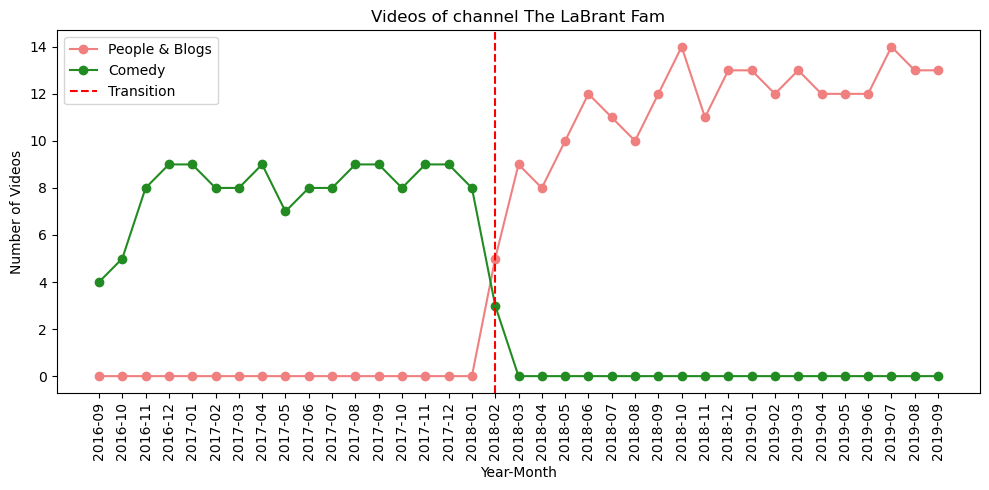

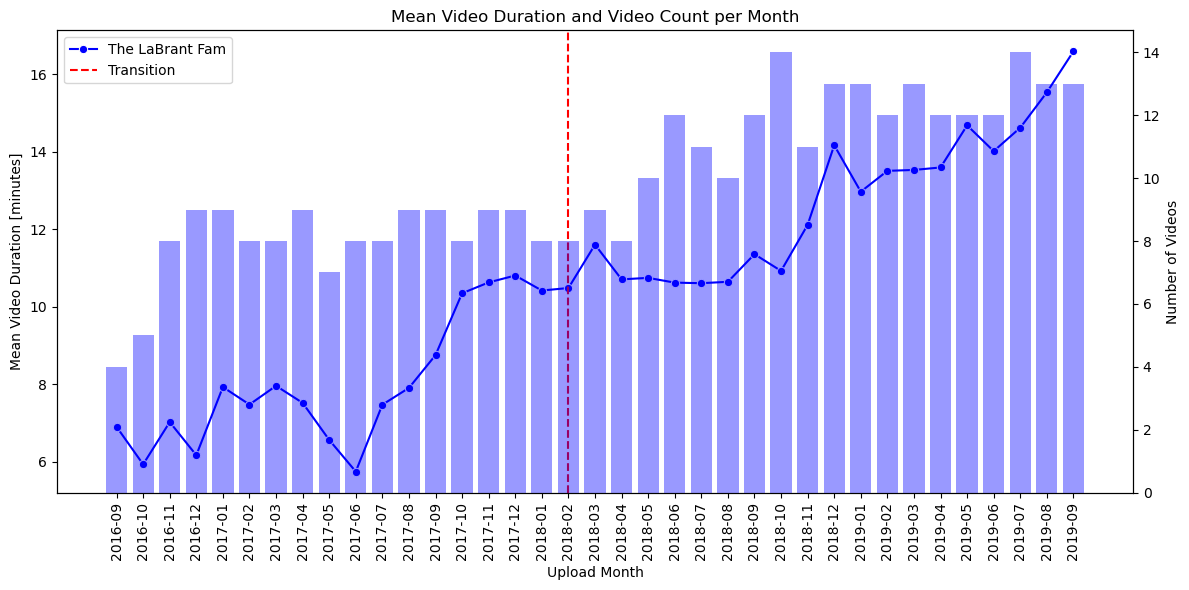

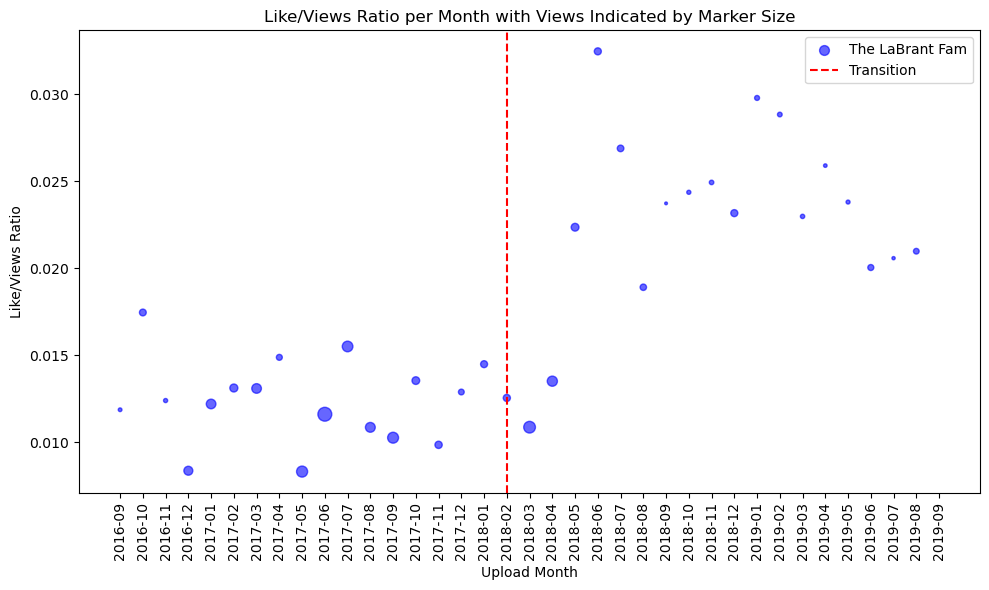

In [ ]:
def channel_id_from_channel_name(channel_name, df_channels):
    channel_id = df_channels[df_channels['name_cc'] == channel_name]['channel']
    return list(channel_id)[0]

channel_name = "The LaBrant Fam"
channel_id = channel_id_from_channel_name(channel_name, df_channels_PB)
df_feather_PB_filt = df_feather_PB[df_feather_PB['channel_id']==channel_id]

visualize_evolution_of_channel(channel_id, 
                               df_feather_PB_filt, 
                               channel_name, 
                               start_date="2016-09", 
                               end_date="2019-09",
                               transition_date="2018-02",
                               streamlit_plot=False)
video_frequency_and_duration(channel_id, 
                               df_feather_PB_filt, 
                               channel_name, 
                               start_date="2016-09", 
                               end_date="2019-09",
                               transition_date="2018-02",
                               streamlit_plot=False)
video_likes_and_views(channel_id, 
                               df_feather_PB_filt, 
                               channel_name, 
                               start_date="2016-09", 
                               end_date="2019-09",
                               transition_date="2018-02",
                               streamlit_plot=False)